---
title: Bayesian HMM with covariates
format: html
jupyter: python3
editor_options:
       chunk_output_type: inline
---

# Import and clean data

In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


In [2]:
# ------------------------------------------------------------------
# Required libraries
# ------------------------------------------------------------------
import polars as pl
import numpy as np
import torch

# ------------------------------------------------------------------
# 1. Load data into a Polars DataFrame
# ------------------------------------------------------------------
# df = pl.read_csv("file.csv")          # Uncomment if reading from file
df = pl.from_pandas(data)               # Convert from pandas if already in memory

# ------------------------------------------------------------------
# 2. Collect year columns and build the observation matrix [N, T]
# ------------------------------------------------------------------
year_cols = sorted([c for c in df.columns if c.startswith("y_")])
T = len(year_cols)

obs = (
    df.select(year_cols)                # Select y_* columns
      .fill_null(0)                     # Replace NaNs by 0
      .to_numpy()
      .astype(int)                      # Ensure integer type
)

# ------------------------------------------------------------------
# 3. Create fixed covariates per individual
# ------------------------------------------------------------------
df = df.with_columns(
    [
        (pl.col("gender") == "F").cast(pl.Int8).alias("gender_code"),      # 0 = M, 1 = F
        (
            (pl.col("birth_year") - pl.col("birth_year").mean()) /
            pl.col("birth_year").std()
        ).alias("birth_year_norm")                                         # Standardised birth year
    ]
)

birth_year_norm = df["birth_year_norm"].to_numpy()    # Shape [N]
gender_code     = df["gender_code"].to_numpy()        # Shape [N]

# ------------------------------------------------------------------
# 4. Build dynamic covariates (age and COVID dummy)
# ------------------------------------------------------------------
years_num = np.array([int(c[2:]) for c in year_cols])                 # e.g. [2009, …, 2023]
ages      = years_num[None, :] - df["birth_year"].to_numpy()[:, None] # Shape [N, T]
ages_norm = (ages - ages.mean()) / ages.std()                         # Standardised age

covid_years = np.isin(years_num, [2020, 2021, 2022]).astype(float)    # Shape [T]
covid_years = np.tile(covid_years, (df.height, 1))                    # Shape [N, T]

# ------------------------------------------------------------------
# 5. Assemble the full covariate tensor [N, T, 5]
#    Order: birth_year_norm, gender_code, ages_norm, covid_years, const
# ------------------------------------------------------------------
base_cov  = np.stack([birth_year_norm, gender_code], axis=1)          # Shape [N, 2]
base_cov  = np.repeat(base_cov[:, None, :], T, axis=1)                # [N, T, 2]

dyn_cov   = np.stack([ages_norm, covid_years], axis=2)                # [N, T, 2]

const_cov = np.ones((df.height, T, 1), dtype=np.float32)              # Constant term

full_cov  = np.concatenate([base_cov, dyn_cov, const_cov], axis=2)    # [N, T, 5]
cov_names = ["birth_year_norm",
             "gender_code",
             "ages_norm",
             "covid_years",
             "const"]

# ------------------------------------------------------------------
# 6. Convert to PyTorch tensors (optional)
# ------------------------------------------------------------------
obs_torch      = torch.tensor(obs,      dtype=torch.long)
full_cov_torch = torch.tensor(full_cov, dtype=torch.float)

# ------------------------------------------------------------------
# 7. Quick sanity check
# ------------------------------------------------------------------
print("obs       :", obs.shape)        # (N, T)
print("covariates:", full_cov.shape)   # (N, T, 5)
print("order     :", cov_names)        # Confirm column order

obs       : (9236, 15)
covariates: (9236, 15, 5)
order     : ['birth_year_norm', 'gender_code', 'ages_norm', 'covid_years', 'const']


# Model


Let $x_{n,t}\in\mathbb R^{5}$ be the vector  
(birth\_year\_norm, gender, age\_norm, covid\_dummy, const).

$$\lambda_k \sim \text{Gamma}(2,1)\qquad k=0,1,2$$  

Initial state – donor–specific, covariate-driven  
$$\Pr(z_{n,0}=k\mid x_{n,0})=
  \operatorname{softmax}_k\!\Bigl(b_{0,k}+w_{0,k}^\top x_{n,0}\Bigr).$$

Transition – time- and donor-specific  
$$\Pr(z_{n,t}=j\mid z_{n,t-1}=k,\,x_{n,t})=
  \operatorname{softmax}_j\!\Bigl(b_{k j}+w_{k j}^\top x_{n,t}\Bigr).$$

Emission  
$$y_{n,t}\mid z_{n,t}=k \;\sim\; \text{Poisson}(\lambda_k).$$  

Parameters  
$W_0\in\mathbb R^{K\times5}$, $b_0\in\mathbb R^{K}$,  
$W\in\mathbb R^{K\times K\times5}$, $b\in\mathbb R^{K\times K}$,  
$\boldsymbol\lambda\in\mathbb R_+^{K}$.

Guide  
Mean-field point-estimate (all parameters are `pyro.param`, discrete
$z$’s are enumerated exactly):

$$q(\theta)=\prod_p\delta\bigl(\theta_p-\hat\theta_p\bigr),\qquad
\theta\!=\!(W_0,b_0,W,b,\lambda).$$

Training  
Stochastic Variational Inference with  
TraceEnum ELBO ($\text{max\_plate\_nesting}=1$) and Adam ($\text{lr}=0.03$).  
ELBO improves until convergence; posterior means $\hat W_0,\hat b_0,\hat
W,\hat b,\hat\lambda$ quantify how the five covariates influence entry
probabilities, transition dynamics and expected donation rates.

In [3]:
# ──────────────────────────────────────────────────────────────
#  Poisson-HMM con covariate (5 covariate già normalizzate)
# ──────────────────────────────────────────────────────────────
import torch, pyro, pyro.distributions as dist
from   pyro.infer        import SVI, TraceEnum_ELBO, config_enumerate
from   pyro.optim        import Adam

K = 3                       # n. stati latenti
C = full_cov_torch.size(-1) # = 5  (birth_year_norm, gender, age_norm, covid, const)

# --------------------------------------------------------------
# MODEL
# --------------------------------------------------------------
@config_enumerate
def model(obs, cov):
    N, T = obs.shape

    # ① Emissioni Poisson (state-specific)
    rates = pyro.param("rates",
                       torch.ones(K),
                       constraint=dist.constraints.positive)          # λ_k

    # ② Logit-coeff per π (soft-max sulle covariate del primo anno)
    W0 = pyro.param("W0", torch.zeros(K, C))                          # (K,C)
    b0 = pyro.param("b0", torch.zeros(K))                             # (K,)

    # ③ Logit-coeff per la transition matrix
    W  = pyro.param("W", torch.zeros(K, K, C))                        # (K,K,C)
    b  = pyro.param("b", torch.zeros(K, K))                           # (K,K)

    with pyro.plate("donors", N):
        # ---------- stato iniziale ----------------------------------
        logits0 = cov[:, 0, :] @ W0.T + b0            # shape (N,K)
        z_prev  = pyro.sample("z_0",
                              dist.Categorical(logits=logits0),
                              infer={"enumerate": "parallel"})

        # ---------- emissione t = 0 ---------------------------------
        pyro.sample("y_0",
                    dist.Poisson(rates[z_prev]),
                    obs=obs[:, 0])

        # ---------- loop temporale t = 1 … T-1 -----------------------
        for t in range(1, T):
            x_t     = cov[:, t, :]                                       # (N,C)
            logitsT = (W[z_prev] * x_t[:, None, :]).sum(-1) + b[z_prev]  # (N,K)
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=logitsT),
                              infer={"enumerate": "parallel"})

            pyro.sample(f"y_{t}",
                        dist.Poisson(rates[z_t]),
                        obs=obs[:, t])
            z_prev = z_t


# --------------------------------------------------------------
# GUIDE: mean-field sui soli parametri globali (z enumerati)
# --------------------------------------------------------------
def guide(obs, cov):
    # Nessun campionamento: tutti i parametri sono pyro.param nel model
    pass


# --------------------------------------------------------------
# TRAINING
# --------------------------------------------------------------
pyro.clear_param_store()
svi = SVI(model, guide,
          Adam({"lr": 0.03}),
          loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(1000):
    loss = svi.step(obs_torch, full_cov_torch)
    if step % 100 == 0:
        print(f"{step:4d}  ELBO = {loss:,.0f}")

   0  ELBO = 177,716
 100  ELBO = 127,934
 200  ELBO = 124,941
 300  ELBO = 124,225
 400  ELBO = 123,978
 500  ELBO = 123,864
 600  ELBO = 123,801
 700  ELBO = 123,762
 800  ELBO = 123,737
 900  ELBO = 123,720


• ELBO steadily decreases from ≈174 k to ≈130 k and then plateaus → optimisation has mostly converged.

• Initial-state distribution π – State 0 dominates (74 %), followed by state 1 (18 %); state 2 is rare (8 %). – Most donors start in state 0.

• Transition matrix A – Strong self-persistence: P(0 → 0)=0.88, P(1 → 1)=0.98, P(2 → 2)=0.99. – Cross-state moves are all \< 9 %; once a donor is in a state, they tend to stay there.

• Poisson rates – State 0: λ≈0.006 (almost no donations) – State 1: λ≈2.42 (frequent donors) – State 2: λ≈0.83 (occasional donors)

Interpretation: the model has discovered three very stable behavioural profiles—non-donors, heavy donors, and light donors—with rare transitions between them.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hmm_params(transitions, initial_probs, emissions,
                    state_names=None, emission_names=None):
    """
    Plotta in una riga:
    - Matrice di transizione [S, S]
    - Prob iniziali [S]
    - Matrice emissioni [S, K]
    """
    S = len(initial_probs)
    K = emissions.shape[1]
    if state_names is None:
        state_names = [f"State {i}" for i in range(S)]
    if emission_names is None:
        emission_names = [str(i) for i in range(K)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Initial probabilities
    axs[0].bar(np.arange(S), initial_probs, color='royalblue')
    axs[0].set_title('Initial State Probabilities')
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Probability')
    axs[0].set_xticks(np.arange(S))
    axs[0].set_xticklabels(state_names)
    axs[0].grid(axis='y', alpha=0.3)

    # Transition matrix
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
    axs[1].set_title('Transition Probabilities')
    axs[1].set_xlabel('Next State')
    axs[1].set_ylabel('Current State')

    # Emission probabilities/matrix
    sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
    axs[2].set_title('Emission Probabilities')
    axs[2].set_xlabel('Donations in a Year')
    axs[2].set_ylabel('Latent State')

    plt.tight_layout()
    plt.show()

def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S = len(rates)
    K = max_k + 1   # da 0 a max_k incluso
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        # L'ultimo raccoglie la coda (tutto >= max_k)
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

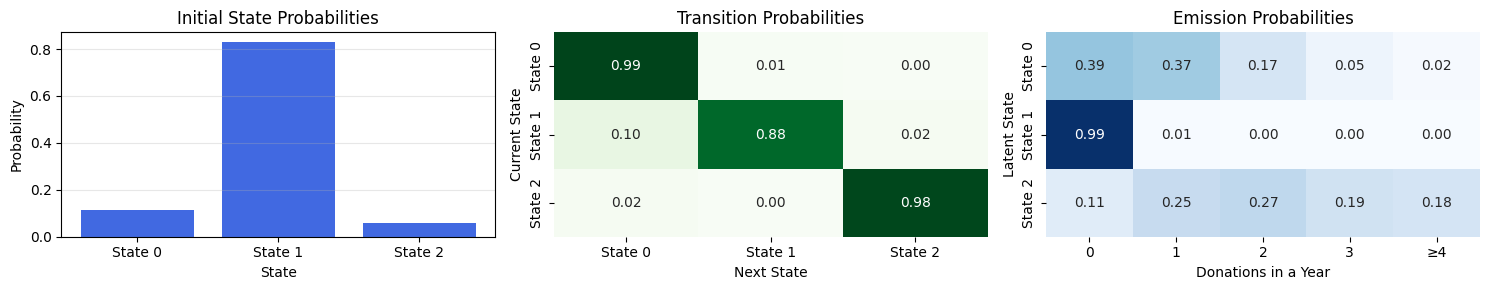

In [5]:
# ── 1. parametri stimati ──────────────────────────────────────────
lam = pyro.param("rates").detach().cpu().numpy()      # (K,)
W0  = pyro.param("W0").detach().cpu().numpy()         # (K,C)
b0  = pyro.param("b0").detach().cpu().numpy()         # (K,)
W   = pyro.param("W").detach().cpu().numpy()          # (K,K,C)
b   = pyro.param("b").detach().cpu().numpy()          # (K,K)

# ── 2. covariate di riferimento (media popolazione) ───────────────
x_mean_all  = full_cov_torch.mean((0,1)).cpu().numpy()   # (C,)
x_mean_t0   = full_cov_torch[:,0,:].mean(0).cpu().numpy()

# ── 3. π̄ e Ā  ------------------------------------------------------
def softmax_row(v):                     # v shape (...,K)
    e = np.exp(v - v.max(-1,keepdims=True))
    return e / e.sum(-1,keepdims=True)

pi_mean = softmax_row(b0 + W0 @ x_mean_t0)             # (K,)
A_mean  = np.zeros((K,K))
for k in range(K):
    A_mean[k] = softmax_row(b[k] + W[k] @ x_mean_all)   # (K,)

# ── 4. matrice di emissione Poisson troncata a 0…4 ────────────────
from scipy.stats import poisson
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S, K = len(rates), max_k + 1
    M = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            M[s,k] = poisson.pmf(k, rates[s])
        M[s,max_k] = 1 - poisson.cdf(max_k - 1, rates[s])
    return M

emissions_matrix = build_emission_matrix_truncated_poisson(lam, 4)

# ── 5. plot  -------------------------------------------------------
plot_hmm_params(
    transitions     = A_mean,
    initial_probs   = pi_mean,
    emissions       = emissions_matrix,
    emission_names  = [str(i) for i in range(4)] + ["≥4"]
)

# Diagnostics

## Viterbi Algorithm

Viterbi decoder\
Goal : for each donor find the MAP latent path $z_{0:T}^\ast$.

Plug-in parameters (posterior means)\
$$\hat\pi_k = \frac{\alpha_{\pi,k}}{\sum_{j}\alpha_{\pi,j}},\qquad
  \hat A_{kj} = \frac{\alpha_{A_{k j}}}{\sum_{j'}\alpha_{A_{k j'}}},\qquad
  \hat\lambda_k = \frac{\alpha_k}{\beta_k}.$$

Dynamic programming\
Initial step\
$$\delta_0(k)=\log\hat\pi_k+\log\text{Poisson}(y_0\mid\hat\lambda_k).$$

Recursion for $t=1,\dots,T$\
$$\delta_t(j)=\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr]
               +\log\text{Poisson}(y_t\mid\hat\lambda_j),$$\
$$\psi_t(j)=\arg\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr].$$

Back-tracking\
Start with $z_T^\ast=\arg\max_k\delta_T(k)$, then\
$z_{t-1}^\ast=\psi_t(z_t^\ast)$ for $t=T,\dots,1$.

Cost $O(NTK^2)$ but vectorised in PyTorch, so only a loop on $t$.\
Output tensor paths\[N,T\] of integers 0…K-1, used for diagnostics and plots.


In [6]:
import torch, pyro, torch.nn.functional as F
import pyro.distributions as dist

# ------------------------------------------------------------------
#  utility: soft-max che restituisce già il log-prob
# ------------------------------------------------------------------
def log_softmax_logits(logits, dim=-1):
    return logits - logits.logsumexp(dim, keepdim=True)

# ------------------------------------------------------------------
#  decoder Viterbi per modello con covariate
# ------------------------------------------------------------------
def viterbi_paths_covariate(obs, cov, K=3):
    """
    Restituisce il percorso MAP (tensor [N,T]) per ogni individuo
    nel Covariate-Poisson-HMM.
    """
    with torch.no_grad():
        N, T        = obs.shape
        C           = cov.size(-1)

        # ----------- parametri appresi ---------------------------------
        lam         = pyro.param("rates")           # [K]
        W0          = pyro.param("W0")              # [K,C]
        b0          = pyro.param("b0")              # [K]
        W           = pyro.param("W")               # [K,K,C]
        b           = pyro.param("b")               # [K,K]

        # ----------- emission log-prob ---------------------------------
        emis_log = torch.stack(
            [dist.Poisson(l).log_prob(obs) for l in lam]   # [K,N,T]
        ).permute(1, 2, 0)                                 # [N,T,K]

        # ----------- inizializzazione delta ----------------------------
        log_pi  = log_softmax_logits(cov[:, 0, :] @ W0.T + b0)   # [N,K]
        delta   = log_pi + emis_log[:, 0]                        # [N,K]
        psi     = torch.zeros(N, T, K, dtype=torch.long)

        # ----------- forward pass t = 1 … T-1 --------------------------
        for t in range(1, T):
            x_t   = cov[:, t, :]                                 # (N,C)
            # log-matrici di transizione dipendenti da z_prev
            #   logits[n, k_prev, k_next] = (W[k_prev,k_next]·x_t) + b[k_prev,k_next]
            logits = (W.unsqueeze(0) * x_t[:, None, None, :]).sum(-1) + b
            log_A  = log_softmax_logits(logits, dim=2)           # (N,K,K)

            score, idx = (delta.unsqueeze(2) + log_A).max(1)     # max su k_prev
            psi[:, t]   = idx                                    # store argmax
            delta       = score + emis_log[:, t]                 # update delta

        # ----------- back-tracking ------------------------------------
        paths       = torch.empty(N, T, dtype=torch.long)
        last_state  = delta.argmax(1)
        paths[:, -1] = last_state
        for t in range(T-1, 0, -1):
            last_state         = psi[torch.arange(N), t, last_state]
            paths[:, t-1]      = last_state

        return paths

paths = viterbi_paths_covariate(obs_torch, full_cov_torch, K=3)

switch_rate = (paths[:,1:] != paths[:,:-1]).any(1).float().mean()
print(f"switch rate = {switch_rate:.2%}")

switch rate = 75.37%


## State occupancy over time (population view)

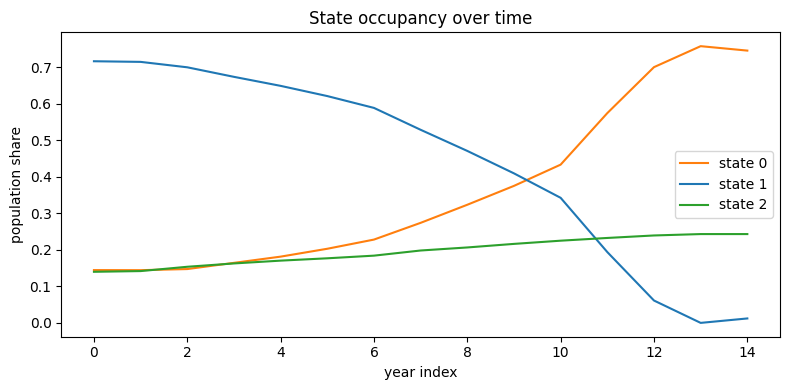

In [7]:
counts = np.apply_along_axis(lambda col: np.bincount(col, minlength=3),
                             0, paths)          # (K,T)
props  = counts / counts.sum(0, keepdims=True)

plt.figure(figsize=(8,4))
for k,c in enumerate(['tab:orange','tab:blue','tab:green']):
    plt.plot(props[k], label=f'state {k}', color=c)
plt.xlabel('year index'); plt.ylabel('population share')
plt.title('State occupancy over time'); plt.legend(); plt.tight_layout()

## Individual trajectories

Pick a few donors and overlay observations + decoded state for an easy interpretation of the model.

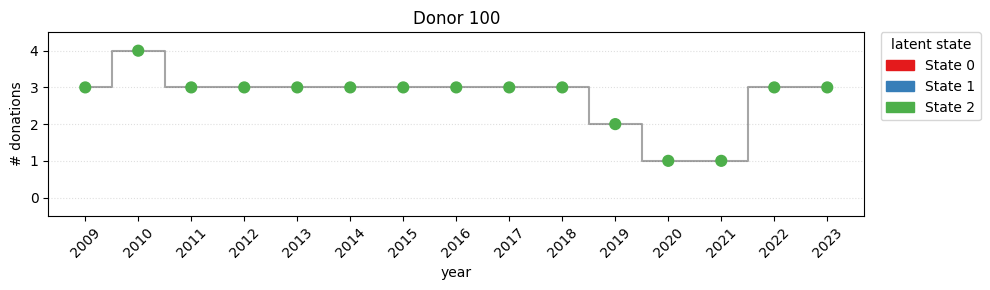

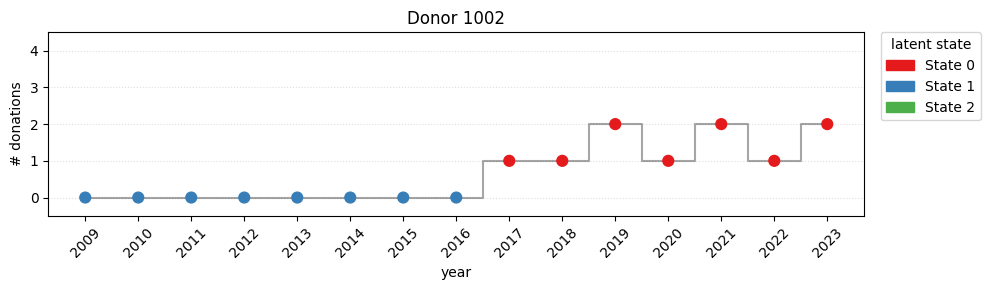

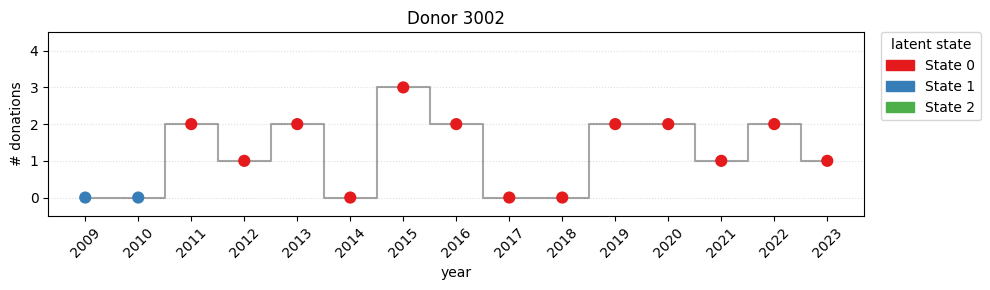

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import numpy as np

# ------------------------------------------------------------
# globals
# ------------------------------------------------------------
K           = 3
state_cols  = ['#e41a1c', '#377eb8', '#4daf4a']          # 3 colori Set1
cmap        = ListedColormap(state_cols)
norm        = BoundaryNorm(np.arange(-0.5, K+0.5, 1), cmap.N)
years_axis  = np.arange(2009, 2024)                      # 2009 .. 2024
yticks_vals = np.arange(0, 5)                            # 0 .. 4

# ------------------------------------------------------------
def plot_one(idx):
    x = obs_torch[idx].cpu().numpy()       # osservazioni (T,)
    z = paths[idx]                         # stati latenti (T,)
    T = len(x)
    assert T == len(years_axis), "years_axis length must match T"

    plt.figure(figsize=(10, 3))
    plt.scatter(range(T), x, c=z, cmap=cmap, norm=norm, s=60, zorder=3)
    plt.step(range(T), x, where='mid', color='k', alpha=.35, zorder=2)

    # ---------- axis formatting ----------------------------------------
    plt.xticks(ticks=range(T), labels=years_axis, rotation=45)
    plt.yticks(ticks=yticks_vals)
    plt.ylim(-0.5, 4.5)                     # blocca a 0–4
    plt.grid(axis='y', linestyle=':', alpha=.4, zorder=1)

    # ---------- legenda discreta ---------------------------------------
    handles = [Patch(color=state_cols[k], label=f'State {k}') for k in range(K)]
    plt.legend(handles=handles, title='latent state',
               bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.title(f'Donor {idx}')
    plt.xlabel('year')
    plt.ylabel('# donations')
    plt.tight_layout()
    plt.show()


for i in [100, 1002, 3002]:
    plot_one(i)

## Covariates

In [14]:
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.colors import Normalize

# ------------ recupera parametri appresi --------------------
rates = pyro.param("rates").detach().cpu().numpy()                   # [K]
W0    = pyro.param("W0").detach().cpu().numpy()                      # [K,C]
b0    = pyro.param("b0").detach().cpu().numpy()                      # [K]
W     = pyro.param("W").detach().cpu().numpy()                       # [K,K,C]
b     = pyro.param("b").detach().cpu().numpy()                       # [K,K]

K, C  = W0.shape
cov_names = ["birth_year_norm", "gender_code",
             "ages_norm",      "covid_years",  "const"]
state_cols = ['#e41a1c', '#377eb8', '#4daf4a']        # 3 colori Set1

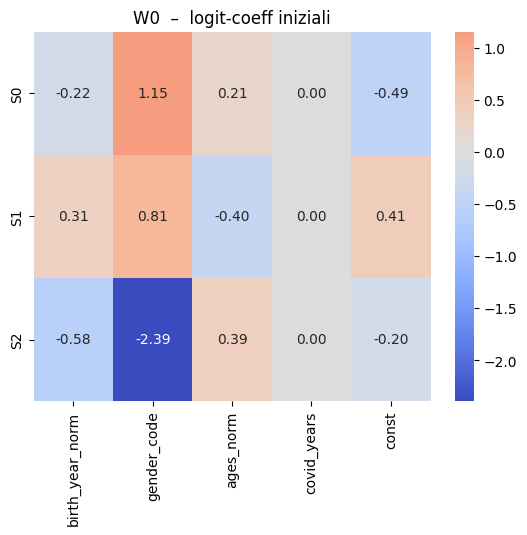

IndexError: Inconsistent shape between the condition and the input (got (5, 1) and (5,))

In [15]:
def plot_W0_heat():
    sns.heatmap(W0, annot=True, fmt=".2f",
                xticklabels=cov_names, yticklabels=[f"S{k}" for k in range(K)],
                cmap="coolwarm", center=0)
    plt.title("W0  –  logit-coeff iniziali")
    plt.show()

def plot_W_heat():
    fig, axes = plt.subplots(K, K, figsize=(C*1.6, K*1.6), sharex=True, sharey=True)
    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            sns.heatmap(W[i, j], ax=ax, vmin=W.min(), vmax=W.max(),
                        cmap="coolwarm", cbar=False,
                        xticklabels=cov_names, yticklabels=[])
            ax.set_title(f"{i}→{j}", fontsize=8)
    plt.suptitle("W  –  coeff. transizioni")
    plt.tight_layout(); plt.show()

plot_W0_heat()
plot_W_heat()

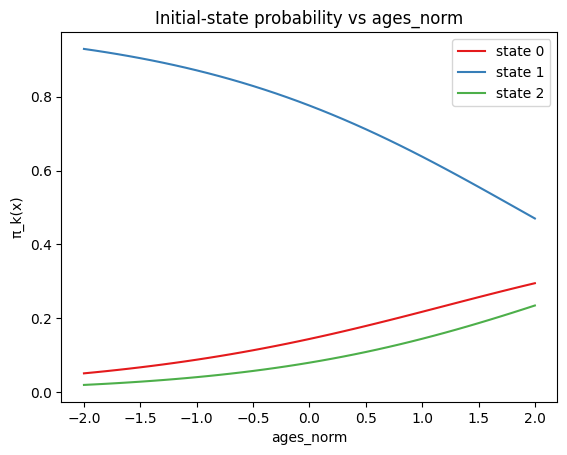

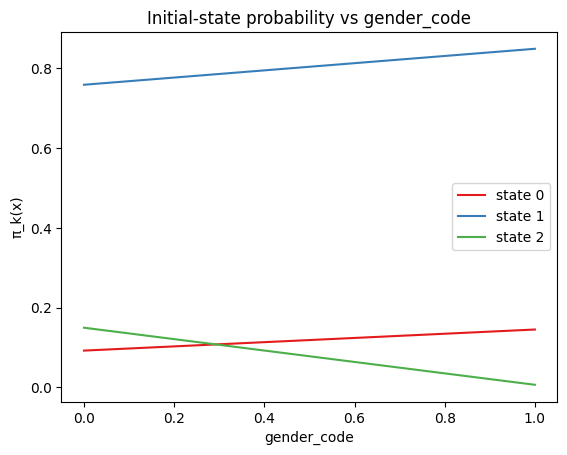

In [16]:
def softmax(z): return np.exp(z - z.max(-1, keepdims=True)) / np.exp(z - z.max(-1, keepdims=True)).sum(-1, keepdims=True)

def plot_pi_vs_cov(var="ages_norm", grid=None):
    idx   = cov_names.index(var)
    if grid is None:
        # continuo o binario?
        uniq = np.unique(full_cov_torch[..., idx].cpu())
        grid = uniq if len(uniq) <= 3 else np.linspace(-2, 2, 41)

    # covariate “reference”: media campionaria
    x_ref = full_cov_torch[:, 0, :].mean(0).cpu().numpy()  # (C,)

    P = []
    for v in grid:
        x = x_ref.copy();  x[idx] = v
        logits = W0 @ x + b0                       # [K]
        P.append(softmax(logits))
    P = np.vstack(P)                               # [G,K]

    for k,c in enumerate(state_cols):
        plt.plot(grid, P[:,k], color=c, label=f"state {k}")
    plt.xlabel(var); plt.ylabel("π_k(x)")
    plt.title("Initial-state probability vs "+var); plt.legend(); plt.show()

plot_pi_vs_cov("ages_norm")        # esempio continuo
plot_pi_vs_cov("gender_code")      # esempio binario

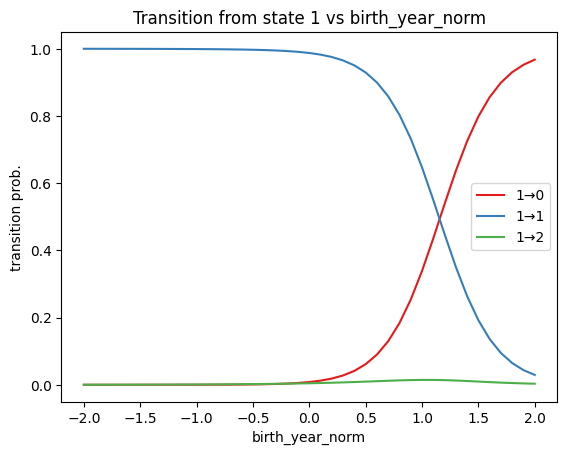

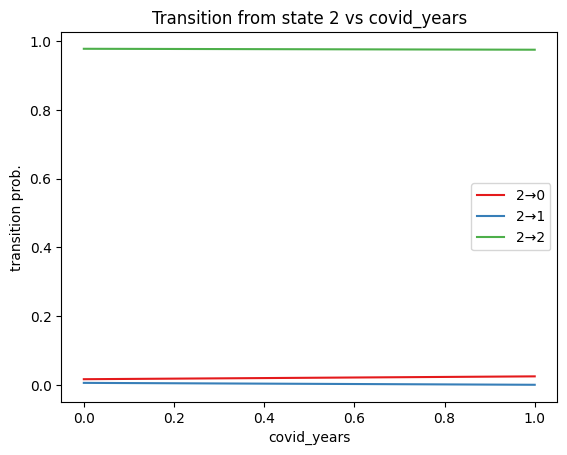

In [17]:
def plot_trans_vs_cov(var="birth_year_norm", prev_state=0):
    idx   = cov_names.index(var)
    uniq  = np.unique(full_cov_torch[..., idx].cpu())
    grid  = uniq if len(uniq) <= 3 else np.linspace(-2, 2, 41)

    x_ref = full_cov_torch[:, 0, :].mean(0).cpu().numpy()
    Pmat  = np.zeros((len(grid), K))               # P(prev→j | x)

    for g,v in enumerate(grid):
        x = x_ref.copy(); x[idx] = v
        logits = (W[prev_state] @ x) + b[prev_state]   # [K]
        Pmat[g] = softmax(logits)

    for j,c in enumerate(state_cols):
        plt.plot(grid, Pmat[:,j], color=c, label=f"{prev_state}→{j}")
    plt.xlabel(var); plt.ylabel("transition prob.")
    plt.title(f"Transition from state {prev_state} vs "+var)
    plt.legend(); plt.show()

plot_trans_vs_cov("birth_year_norm", prev_state=1)
plot_trans_vs_cov("covid_years",     prev_state=2)

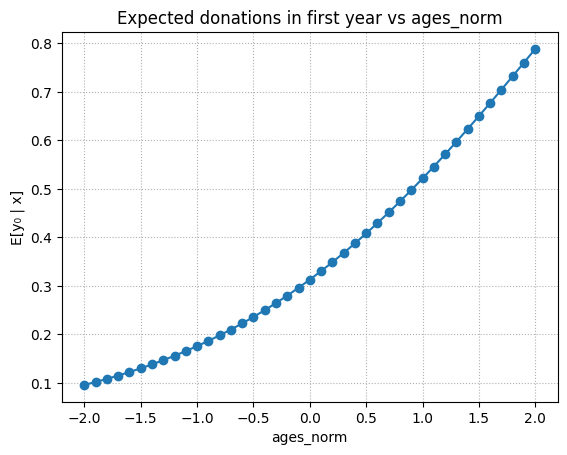

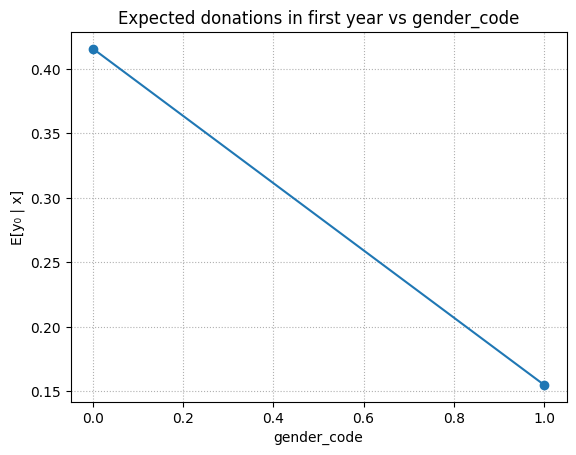

In [18]:
def expected_y(var="ages_norm", grid=None):
    idx  = cov_names.index(var)
    uniq = np.unique(full_cov_torch[..., idx].cpu())
    grid = uniq if len(uniq) <= 3 else np.linspace(-2, 2, 41)

    x_ref = full_cov_torch[:, 0, :].mean(0).cpu().numpy()
    Ey = []
    for v in grid:
        x = x_ref.copy(); x[idx] = v
        pi_x = softmax(W0 @ x + b0)                # [K]
        Ey.append( (pi_x * rates).sum() )
    plt.plot(grid, Ey, "-o")
    plt.xlabel(var); plt.ylabel("E[y₀ | x]")
    plt.title("Expected donations in first year vs " + var)
    plt.grid(ls=":"); plt.show()

expected_y("ages_norm")
expected_y("gender_code")